In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data_path = 'C:/Users/aswin/Downloads/CNN_train_dataset'
annotation_path = r"C:\Users\aswin\Downloads\CNN_train_dataset\TSRD-Train Annotation\TsignRecgTrain4170Annotation.txt"
images_path = os.path.join(data_path, 'tsrd-train')
IMG_SIZE = 64

In [3]:
data = []
with open(annotation_path, 'r') as f:
    for line in f:
        parts = line.strip().split(';')
        if len(parts) >= 8:
            filename, img_w, img_h, box_w, box_h, box_x, box_y, label = parts[:8]
            data.append({'filename': filename, 'label': int(label)})

df = pd.DataFrame(data)
print("Training samples loaded:", df.shape)

Training samples loaded: (4170, 2)


In [4]:
def load_data(df, images_path):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(images_path, row['filename'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(row['label'])
    return np.array(X), np.array(y)

X_train, y_train = load_data(df, images_path)
X_train = X_train.astype('float32') / 255.0  # Normalize

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Shuffle and split data manually (10% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

In [7]:
num_classes = len(np.unique(y_train))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\aswin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,632,634 (6.23 MB)

 Trainable params: 1,632,634 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stop]
)


C:\Users\aswin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.2217 - loss: 3.1692 - val_accuracy: 0.5228 - val_loss: 1.6561
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.5338 - loss: 1.6444 - val_accuracy: 0.7362 - val_loss: 0.9204
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.6854 - loss: 1.0387 - val_accuracy: 0.7890 - val_loss: 0.6175
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.7766 - loss: 0.7167 - val_accuracy: 0.8034 - val_loss: 0.5364
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.8280 - loss: 0.5536 - val_accuracy: 0.8945 - val_loss: 0.2724
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.8618 - loss: 0.4455 - val_accuracy: 0.9209 - val_loss: 0.2253
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.8871 - loss: 0.3704 - val_accuracy: 0.9305 - val_loss: 0.1872
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.9068 - loss: 0

In [ ]:
# Save the model to disk so you can reuse it later
model.save('final_tsrd_model.h5')
print("✅ Model saved as 'final_tsrd_model.h5'")


In [9]:
# Test dataset paths
test_data_path = r"C:\Users\aswin\Downloads\CNN_test_dataset"
test_annotation_path = r"C:\Users\aswin\Downloads\CNN_test_dataset\TSRD-Test Annotation\TsignRecgTest1994Annotation.txt"
test_images_path = "C:/Users/aswin/Downloads/CNN_test_dataset/TSRD-Test"

# Load test annotations
test_data = []
with open(test_annotation_path, 'r') as f:
    for line in f:
        parts = line.strip().split(';')
        if len(parts) >= 8:
            filename, img_w, img_h, box_w, box_h, box_x, box_y, label = parts[:8]
            test_data.append({'filename': filename, 'label': int(label)})

test_df = pd.DataFrame(test_data)


In [10]:
def load_data(df, images_path):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(images_path, row['filename'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))
            X.append(img)
            y.append(row['label'])
    return np.array(X), np.array(y)

X_test, y_test = load_data(test_df, test_images_path)
X_test = X_test.astype('float32') / 255.0


In [11]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Final Test Accuracy: {accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6071 - loss: 2.8135
✅ Final Test Accuracy: 0.5998


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

           0       0.55      0.86      0.67        14
           1       0.13      0.83      0.23        12
           2       0.53      0.33      0.41        60
           3       0.68      0.76      0.72        84
           4       0.83      0.34      0.49        58
           5       0.28      0.72      0.40        50
           6       0.71      0.80      0.75        30
           7       0.39      0.36      0.38        50
           8       0.86      0.86      0.86        14
          10       1.00      0.97      0.98        60
          11       0.94      0.75      0.84       130
          12       0.91      0.91      0.91        22
          13       0.88      0.48      0.62        92
          14       0.57      0.67      0.62        12
          15       0.00      0.00      0.00        36
          16       0.47      0.92      0.62        76
          17       1.00      0.24      0.

C:\Users\aswin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aswin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aswin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aswin\anaconda3\Lib\site-packages\sklea

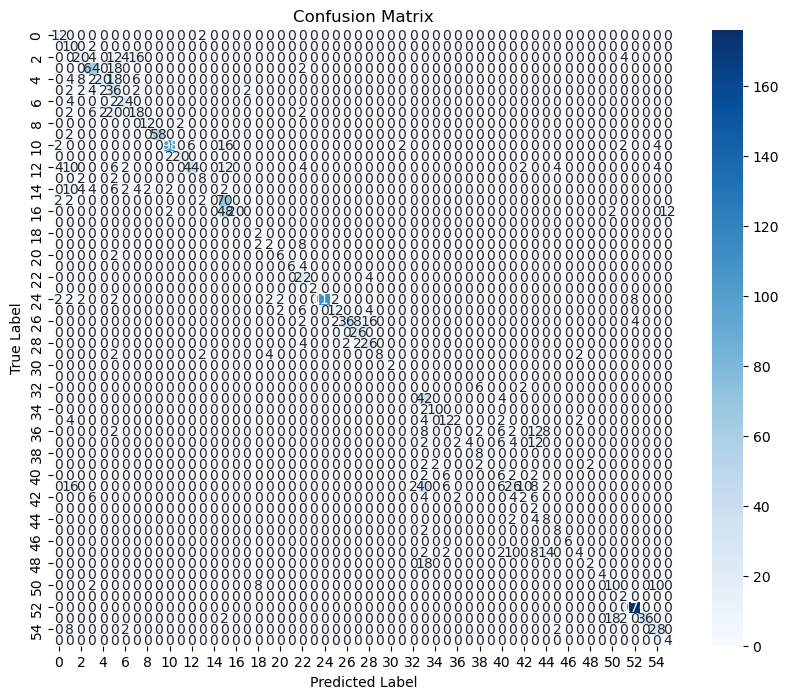

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


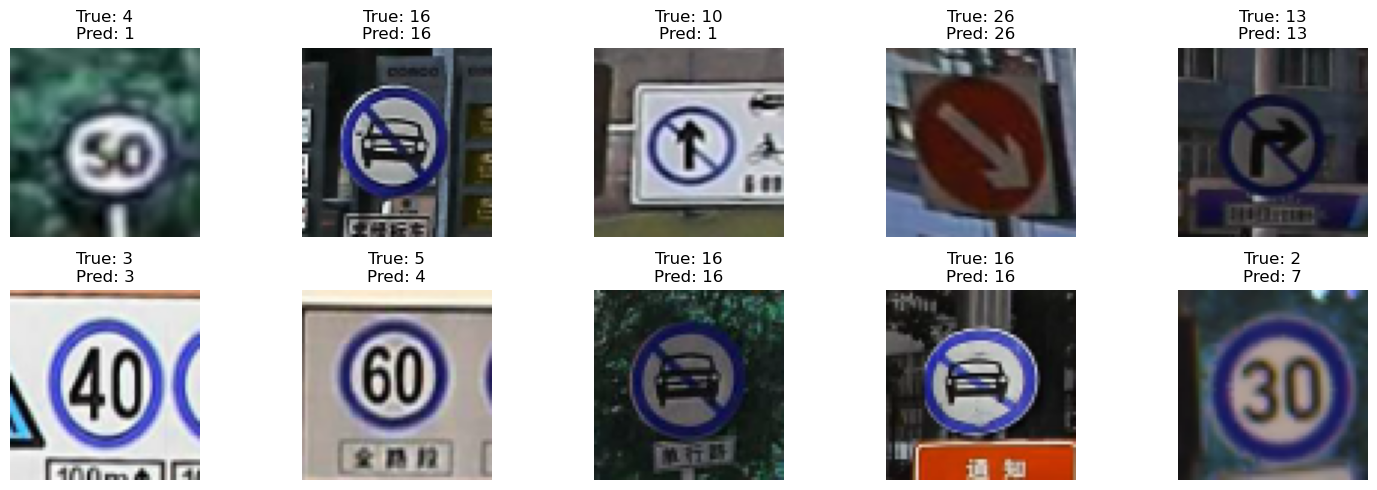

In [13]:
import random

indices = random.sample(range(len(X_test)), 10)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_preds = np.argmax(model.predict(sample_images), axis=1)

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_labels[i]}\nPred: {sample_preds[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
